In [1]:
import spacy
import gensim
import pandas as pd
import nltk
import numpy as np
import re
import string
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from gensim.models.fasttext import FastText
from MeanVectorizer import MeanEmbeddingVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

nltk.download('punkt')
nlp = spacy.blank('id')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\egapa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_excel("dataset1000.xlsx")
df.head()

,label,komentar
0,positif,Oke pak boss!!
1,positif,PROBOWO is the WINNER of PEMILU 2014
2,positif,Hidup Pak Prabowo ..
3,positif,Ganteng bgt Pak :)
4,positif,ayo pak rujuk lagi sama bu titiek..hehhehe


In [3]:
df['label'].value_counts()

positif    1549
negatif     332
netral      120
Name: label, dtype: int64

In [4]:
komentar = df['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df['komentar'] = komentar
df

,label,komentar
0,positif,"[oke, pak, boss]"
1,positif,"[probowo, is, the, winner, of, pemilu]"
2,positif,"[hidup, pak, prabowo]"
3,positif,"[ganteng, bgt, pak]"
4,positif,"[ayo, pak, rujuk, lagi, sama, bu, titiek, hehh..."
...,...,...
1996,negatif,"[jangan, lupa, n, jangan, dugal, y, buat, yg, ..."
1997,negatif,"[no, we]"
1998,negatif,"[pasang, foto, biar, laku, ya, joko, xixixixi]"
1999,negatif,"[gw, pilih, no, prabowo, hata]"


In [5]:
df_tambahan = pd.read_excel("dataset_tambahan.xlsx")
df_tambahan

,label,komentar
0,negatif,"Soal jln Jatibaru,polisi tdk bs GERTAK gubernu..."
1,negatif,"Sesama cewe lho (kayaknya), harusnya bisa lebi..."
2,negatif,"Jln Jatibaru,bagian dari wilayah Tn Abang.Peng..."
3,negatif,"Dari sekian banyak thread yang aku baca, threa..."
4,negatif,"Contoh mereka yg gemar menyudutkan, teriak pal..."
...,...,...
2093,netral,bukan saya yang tidak-mau merit sat ini hubung...
2094,netral,Baru lihat kabar Teman nge gosip dan penuh inf...
2095,netral,Mengubah kebiasaan seseorang yg kurang baik it...
2096,netral,nah diam lebih bagus yaudah saya diam saja deh...


In [6]:
komentar = df_tambahan['komentar'].astype(str)

#Lower case
komentar = komentar.apply(lambda x: x.lower())

#Remove URL
komentar = komentar.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*', '', x, flags=re.MULTILINE))

#Remove Number
komentar = komentar.apply(lambda x: re.sub(r"\d", "", x))

#Before Punctuation
komentar = komentar.apply(lambda x: re.sub(r'(?<=[,.])(?=[^\s])', r' ', x))

#Punctuation
komentar = komentar.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

#Remove Non Alphanumeric
komentar = komentar.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', x))

#Tokenizing
komentar = komentar.apply(lambda x: nltk.tokenize.word_tokenize(x))

df_tambahan['komentar'] = komentar
df_tambahan

,label,komentar
0,negatif,"[soal, jln, jatibaru, polisi, tdk, bs, gertak,..."
1,negatif,"[sesama, cewe, lho, kayaknya, harusnya, bisa, ..."
2,negatif,"[jln, jatibaru, bagian, dari, wilayah, tn, aba..."
3,negatif,"[dari, sekian, banyak, thread, yang, aku, baca..."
4,negatif,"[contoh, mereka, yg, gemar, menyudutkan, teria..."
...,...,...
2093,netral,"[bukan, saya, yang, tidakmau, merit, sat, ini,..."
2094,netral,"[baru, lihat, kabar, teman, nge, gosip, dan, p..."
2095,netral,"[mengubah, kebiasaan, seseorang, yg, kurang, b..."
2096,netral,"[nah, diam, lebih, bagus, yaudah, saya, diam, ..."


In [7]:
df = df[df.komentar.astype(bool)]
df_tambahan = df_tambahan[df_tambahan.komentar.astype(bool)]

X_temp = df['komentar']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_temp, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
X_train = X_train.append(df_tambahan.komentar)
y_train = y_train.append(df_tambahan.label)
y_train.value_counts()

negatif    1364
positif    1237
netral     1085
Name: label, dtype: int64

In [10]:
model = FastText.load_fasttext_format('../../cc.id.300.bin')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  """Entry point for launching an IPython kernel.


In [11]:
mean_vec_tr = MeanEmbeddingVectorizer(model)

In [12]:
X_train_vector = mean_vec_tr.transform(X_train)
X_test_vector = mean_vec_tr.transform(X_test)

In [13]:
lc=preprocessing.LabelEncoder()
lc.fit(y)

LabelEncoder()

In [14]:
y_train_enc=lc.transform(y_train)
y_test_enc=lc.transform(y_test)

In [15]:
weights = y_train_enc
weights = np.choose(weights, [0.9, 1.3, 1])

train=xgb.DMatrix(X_train_vector,label=y_train_enc, weight=weights)
test=xgb.DMatrix(X_test_vector,label=y_test_enc)

print("\nIni Weights\n", weights, "\n")
print("Ini y_train_encode\n", y_train_enc, "\n")


Ini Weights
 [1.3 1.3 0.9 ... 1.3 1.3 1.3] 

Ini y_train_encode
 [1 1 0 ... 1 1 1] 



In [16]:
param = {}

# Learning Rate:  0.01
# Gamma:  0.3
# Max Depth:  7
# Subsample:  0.4
# Colsample Bytree:  0.6
# Alpha:  0
# Lamda:  1.5
# Min Child Weight:  1
# Number of Trees:  1000

param['num_class']=len(set(y))
param['objective'] = 'multi:softmax'
param['learning_rate'] = 0.01
param['gamma'] = 0.3
param['max_depth'] = 4
param['subsample'] = 0.4
param['colsample_bytree'] = 0.6
param['reg_alpha'] = 0
param['reg_lambda'] = 1.5
param['min_child_weight'] = 1
num_round = 1000

watchlist = [(train, 'train'), (test, 'test')]
bst = xgb.train(param, train, num_round, watchlist)

[0]	train-merror:0.34100	test-merror:0.37186
[1]	train-merror:0.29922	test-merror:0.34171
[2]	train-merror:0.27354	test-merror:0.31910
[3]	train-merror:0.25716	test-merror:0.31407
[4]	train-merror:0.25065	test-merror:0.31407
[5]	train-merror:0.24719	test-merror:0.29397
[6]	train-merror:0.24314	test-merror:0.28643
[7]	train-merror:0.23961	test-merror:0.29397
[8]	train-merror:0.23460	test-merror:0.29648
[9]	train-merror:0.23594	test-merror:0.28895
[10]	train-merror:0.23489	test-merror:0.28643
[11]	train-merror:0.23104	test-merror:0.28643
[12]	train-merror:0.22939	test-merror:0.29900
[13]	train-merror:0.23223	test-merror:0.30151
[14]	train-merror:0.22905	test-merror:0.30151
[15]	train-merror:0.22926	test-merror:0.29648
[16]	train-merror:0.22701	test-merror:0.29900
[17]	train-merror:0.22704	test-merror:0.29900
[18]	train-merror:0.22492	test-merror:0.29900
[19]	train-merror:0.22534	test-merror:0.29900
[20]	train-merror:0.22614	test-merror:0.29397
[21]	train-merror:0.22335	test-merror:0.2939

[177]	train-merror:0.17907	test-merror:0.27136
[178]	train-merror:0.17744	test-merror:0.26884
[179]	train-merror:0.17744	test-merror:0.27136
[180]	train-merror:0.17814	test-merror:0.27136
[181]	train-merror:0.17667	test-merror:0.27136
[182]	train-merror:0.17674	test-merror:0.27136
[183]	train-merror:0.17597	test-merror:0.27136
[184]	train-merror:0.17628	test-merror:0.26633
[185]	train-merror:0.17574	test-merror:0.27136
[186]	train-merror:0.17514	test-merror:0.27136
[187]	train-merror:0.17548	test-merror:0.26633
[188]	train-merror:0.17512	test-merror:0.26633
[189]	train-merror:0.17592	test-merror:0.26884
[190]	train-merror:0.17504	test-merror:0.26884
[191]	train-merror:0.17581	test-merror:0.26884
[192]	train-merror:0.17581	test-merror:0.26884
[193]	train-merror:0.17571	test-merror:0.26884
[194]	train-merror:0.17522	test-merror:0.26884
[195]	train-merror:0.17499	test-merror:0.26884
[196]	train-merror:0.17362	test-merror:0.26884
[197]	train-merror:0.17419	test-merror:0.26884
[198]	train-m

[352]	train-merror:0.14222	test-merror:0.25628
[353]	train-merror:0.14142	test-merror:0.25377
[354]	train-merror:0.14142	test-merror:0.25628
[355]	train-merror:0.14118	test-merror:0.25879
[356]	train-merror:0.14131	test-merror:0.25377
[357]	train-merror:0.14121	test-merror:0.25377
[358]	train-merror:0.14111	test-merror:0.25628
[359]	train-merror:0.14015	test-merror:0.25879
[360]	train-merror:0.13982	test-merror:0.25628
[361]	train-merror:0.13982	test-merror:0.25628
[362]	train-merror:0.14015	test-merror:0.25628
[363]	train-merror:0.13992	test-merror:0.25628
[364]	train-merror:0.13958	test-merror:0.25628
[365]	train-merror:0.13992	test-merror:0.25628
[366]	train-merror:0.13938	test-merror:0.25628
[367]	train-merror:0.13902	test-merror:0.25879
[368]	train-merror:0.13925	test-merror:0.25879
[369]	train-merror:0.13899	test-merror:0.25879
[370]	train-merror:0.13925	test-merror:0.25879
[371]	train-merror:0.13933	test-merror:0.25879
[372]	train-merror:0.13925	test-merror:0.25628
[373]	train-m

[527]	train-merror:0.11130	test-merror:0.25879
[528]	train-merror:0.11058	test-merror:0.25879
[529]	train-merror:0.11081	test-merror:0.25879
[530]	train-merror:0.10988	test-merror:0.25879
[531]	train-merror:0.10996	test-merror:0.25628
[532]	train-merror:0.10998	test-merror:0.25628
[533]	train-merror:0.10998	test-merror:0.25628
[534]	train-merror:0.10973	test-merror:0.25628
[535]	train-merror:0.10965	test-merror:0.25628
[536]	train-merror:0.10939	test-merror:0.25879
[537]	train-merror:0.10939	test-merror:0.25628
[538]	train-merror:0.10939	test-merror:0.25879
[539]	train-merror:0.10916	test-merror:0.25879
[540]	train-merror:0.10916	test-merror:0.25628
[541]	train-merror:0.10916	test-merror:0.26131
[542]	train-merror:0.10882	test-merror:0.25879
[543]	train-merror:0.10913	test-merror:0.25879
[544]	train-merror:0.10856	test-merror:0.25879
[545]	train-merror:0.10872	test-merror:0.25879
[546]	train-merror:0.10875	test-merror:0.25879
[547]	train-merror:0.10872	test-merror:0.25879
[548]	train-m

[702]	train-merror:0.08686	test-merror:0.25377
[703]	train-merror:0.08653	test-merror:0.25377
[704]	train-merror:0.08663	test-merror:0.25377
[705]	train-merror:0.08655	test-merror:0.25377
[706]	train-merror:0.08606	test-merror:0.25377
[707]	train-merror:0.08604	test-merror:0.25628
[708]	train-merror:0.08614	test-merror:0.25126
[709]	train-merror:0.08591	test-merror:0.25377
[710]	train-merror:0.08591	test-merror:0.25377
[711]	train-merror:0.08591	test-merror:0.25126
[712]	train-merror:0.08591	test-merror:0.25377
[713]	train-merror:0.08557	test-merror:0.25377
[714]	train-merror:0.08557	test-merror:0.25377
[715]	train-merror:0.08557	test-merror:0.25126
[716]	train-merror:0.08534	test-merror:0.25126
[717]	train-merror:0.08488	test-merror:0.25126
[718]	train-merror:0.08485	test-merror:0.25126
[719]	train-merror:0.08462	test-merror:0.25126
[720]	train-merror:0.08428	test-merror:0.25126
[721]	train-merror:0.08428	test-merror:0.25126
[722]	train-merror:0.08405	test-merror:0.25126
[723]	train-m

[877]	train-merror:0.06751	test-merror:0.25879
[878]	train-merror:0.06774	test-merror:0.25879
[879]	train-merror:0.06774	test-merror:0.25879
[880]	train-merror:0.06753	test-merror:0.25879
[881]	train-merror:0.06753	test-merror:0.25879
[882]	train-merror:0.06777	test-merror:0.25879
[883]	train-merror:0.06694	test-merror:0.25879
[884]	train-merror:0.06648	test-merror:0.25879
[885]	train-merror:0.06648	test-merror:0.25879
[886]	train-merror:0.06624	test-merror:0.25879
[887]	train-merror:0.06601	test-merror:0.25879
[888]	train-merror:0.06635	test-merror:0.25879
[889]	train-merror:0.06588	test-merror:0.25879
[890]	train-merror:0.06588	test-merror:0.25879
[891]	train-merror:0.06611	test-merror:0.25879
[892]	train-merror:0.06555	test-merror:0.25879
[893]	train-merror:0.06521	test-merror:0.25879
[894]	train-merror:0.06521	test-merror:0.25879
[895]	train-merror:0.06544	test-merror:0.25879
[896]	train-merror:0.06521	test-merror:0.25879
[897]	train-merror:0.06480	test-merror:0.25879
[898]	train-m

In [17]:
pred = bst.predict(test)
pred2 = bst.predict(train)

In [18]:
predictions = lc.inverse_transform(list(map(int,pred)))
predictions2 = lc.inverse_transform(list(map(int,pred2)))

In [19]:
test_score = accuracy_score(predictions,y_test)
train_score = accuracy_score(predictions2, y_train)

print("\nTest Score\n", test_score, "\n")
print("Train Score\n", train_score, "\n")
print("CONFUSSION MATRIX\n", confusion_matrix(y_test, predictions), "\n")
print("CLASSIFICATION REPORT\n", classification_report(y_test, predictions), "\n")


Test Score
 0.7412060301507538 

Train Score
 0.9403147042864894 

CONFUSSION MATRIX
 [[ 19   4  43]
 [  6   5  11]
 [ 26  13 271]] 

CLASSIFICATION REPORT
               precision    recall  f1-score   support

     negatif       0.37      0.29      0.32        66
      netral       0.23      0.23      0.23        22
     positif       0.83      0.87      0.85       310

    accuracy                           0.74       398
   macro avg       0.48      0.46      0.47       398
weighted avg       0.72      0.74      0.73       398
 



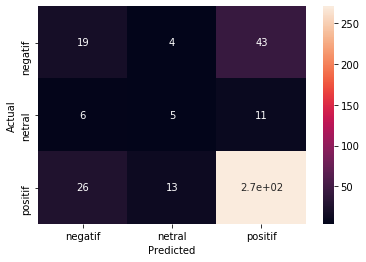

In [20]:
import seaborn as sn

confusion = pd.crosstab(y_test, predictions, rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion, annot=True)

In [21]:
# # Create XGB Classifier object
# xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "gpu_predictor", verbosity = 1, objective = "multi:softmax")

# # Create parameter grid
# # parameters = {"learning_rate": [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001],
# #                "gamma" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1, 1.5, 2, 3, 4, 6],
# #                "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20],
# #                "colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
# #                "subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
# #                "reg_alpha": [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
# #                "reg_lambda": [1, 1.5, 2, 3, 4.5, 4, 5],
# #                "min_child_weight": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
# #                "n_estimators": [100, 250, 500, 1000],
# #                "num_boost_round": [100, 250, 500, 750, 1000]}

# parameters = {"learning_rate": [0.1, 0.01, 0.001],
#                "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
#                "max_depth": [2, 4, 7, 10],
#                "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
#                "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
#                "reg_alpha": [0, 0.5, 1],
#                "reg_lambda": [1, 1.5, 2, 3, 4.5],
#                "min_child_weight": [1, 3, 5, 7],
#                "n_estimators": [100, 250, 500, 1000]}

# from sklearn.model_selection import RandomizedSearchCV
# # Create RandomizedSearchCV Object
# xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
#                              cv = 10, verbose = 3, random_state = 40 )
           
# # Fit the model
# model_xgboost = xgb_rscv.fit(X_train_vector, y_train)

# # Model best estimators
# print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
# print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
# print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
# print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
# print("Colsample Bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
# print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
# print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
# print("Min Child Weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
# print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])